In [1]:
# imports
import act
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xwrf
import pyart
from datetime import datetime, timedelta
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

import cmweather
import pandas as pd
import glob

from bokeh.models.formatters import DatetimeTickFormatter
import hvplot.xarray
import holoviews as hv
hv.extension("bokeh")

import sys
sys.path.insert(0, '/data/home/jeissner/arm-summer-school-2024/tutorials/comble/')
from functions_plotting_tutorial import load_sims


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
# merge all times together 
raw_wrf_output_dir = '/data/project/ARM_Summer_School_2024_Data/comble-mip/output_les/wrf/WRF_Lx25_dx100_FixN_raw/'
raw = sorted(glob.glob(raw_wrf_output_dir+'wrfstat*'))
raw_wrfout_files = sorted(glob.glob(raw_wrf_output_dir+'wrfout*'))
ds = xr.open_mfdataset(raw,
                       chunks={},
                       coords="minimal",decode_times=False, concat_dim='Time', combine='nested')


In [3]:
ds

<xarray.Dataset> Size: 101GB
Dimensions:         (Time: 121, bottom_top: 159, bottom_top_stag: 160,
                     south_north: 256, west_east: 256, west_east_stag: 257,
                     south_north_stag: 257)
Coordinates:
    XTIME           (Time) float32 484B dask.array<chunksize=(6,), meta=np.ndarray>
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, south_north,
                                west_east, west_east_stag, south_north_stag
Data variables: (12/231)
    Times           (Time) |S19 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    CST_CLDLOW      (Time) float32 484B dask.array<chunksize=(6,), meta=np.ndarray>
    CST_CLDTOT      (Time) float32 484B dask.array<chunksize=(6,), meta=np.ndarray>
    CST_CLDTOT2     (Time) float32 484B dask.array<chunksize=(6,), meta=np.ndarray>
    CST_CLWP        (Time) float32 484B dask.array<chunksize=(6,), meta=np.ndarray>
    CST_RWP         (Time) float32 484B dask.array<chunksize=(6,), meta=np.ndarray>
    ...              ...
    CSS_CLDLOW      (Time, south_north, west_east) float32 32MB dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    CSS_OPDC        (Time, south_north, west_east) float32 32MB dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    CSS_OPDR        (Time, south_north, west_east) float32 32MB dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    CSS_OPDI        (Time, south_north, west_east) float32 32MB dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    CSS_OPDS        (Time, south_north, west_east) float32 32MB dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
    CSS_OPDG        (Time, south_north, west_east) float32 32MB dask.array<chunksize=(1, 128, 128), meta=np.ndarray>
Attributes: (12/85)
    TITLE:                            OUTPUT FROM WRF V4.2.2 MODEL
    START_DATE:                      2020-03-12_22:00:00
    WEST-EAST_GRID_DIMENSION:        257
    SOUTH-NORTH_GRID_DIMENSION:      257
    BOTTOM-TOP_GRID_DIMENSION:       160
    DX:                              100.0
    ...                              ...
    ISLAKE:                          0
    ISICE:                           0
    ISURBAN:                         0
    ISOILWATER:                      0
    HYBRID_OPT:                      0
    ETAC:                            0.0

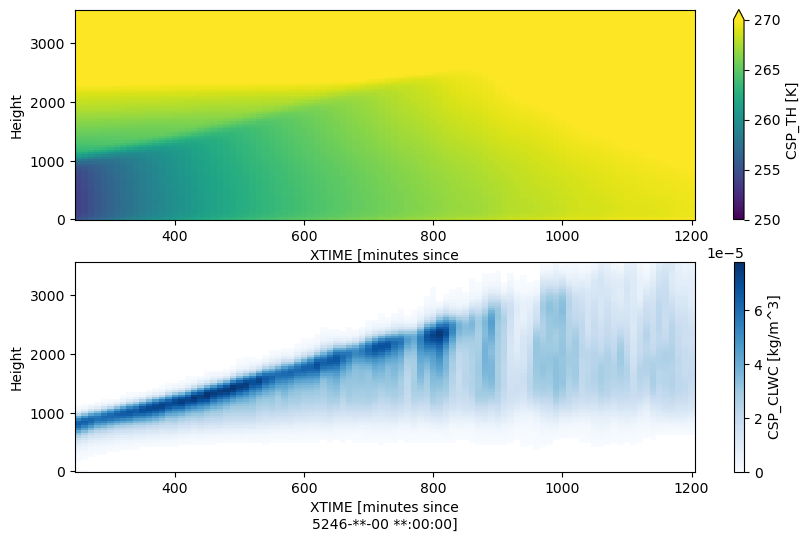

In [4]:
#f,axs = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1,1,1]})
newZ = np.mean(ds.CSP_Z, axis=0)

fig, axs = plt.subplots(figsize=[10, 6],nrows=2)
newTH = ds.CSP_TH.assign_coords(Height=("bottom_top", newZ.data))
newLWC = ds.CSP_CLWC.assign_coords(Height=("bottom_top", newZ.data))
#new = ds.CSP_TKE_DI.assign_coords(Height=("bottom_top", newZ.data))

cmap0 = LinearSegmentedColormap.from_list('', ['white', *plt.cm.Blues(np.arange(255))])
newTH.sel(bottom_top=slice(0, 90),Time=slice(25,121)).plot(x='XTIME', y='Height',ax=axs[0],vmin=250,vmax=270)
newLWC.sel(bottom_top=slice(0, 90),Time=slice(25,121)).plot(x='XTIME', y='Height',ax=axs[1], cmap=cmap0)
#new.sel(z=slice(0,80)).plot(x='Time', y='Height',ax=axs[2], cmap=cmap0)
#ds.CST_CLDLOW.plot(x='Time', color='k',ax=ax2)
plt.show()


#### fig = plt.figure(figsize=[15, 7])
map_panel_axes = [0.05, 0.38, 0.5, 0.4]
y_cut_panel_axes = [0.05, 0.1, 0.4, 0.2]
ax1 = fig.add_axes(map_panel_axes)
ax2 = fig.add_axes(y_cut_panel_axes)
l4 = ds.CSS_CLWP[0].plot(x='x', y='y',ax=ax1)
l5 = ds.CSS_CLDLOW[0].plot(x='x', y='y',ax=ax2)


# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.5)

def animate(i):
    ax1.cla()
    ax2.cla()
    ## in this examples, i takes values 0-10 by steps of 0.01 (the frames in the animation call)
    ## and will represent the frequency of the 2nd wave in the top subplot
    arts = []
    l1, = ds.CSS_CLWP[i].plot(x='x', y='y',ax=ax1)
    l3, = ds.CSS_CLDLOW[i].plot(x='x', y='y',ax=ax2)
    arts = [l1,l3]
    return my_lines ## return updated artists

ani = animation.FuncAnimation(fig, animate, frames=20)
ani.save('test.mp4', writer=animation.FFMpegWriter(fps=6, bitrate=5000, codec="h264"), dpi=150)
plt.show()

In [5]:
M = []
for i in range(0,121):
    pres = ds.CSP_P[i,:]
    x = np.abs(pres/100. - 850.).argmin()
    m = ds.CSP_TH[i,x] - ds.CSP_TH[i,0]
    M.append(m)
np.shape(M)

(121,)

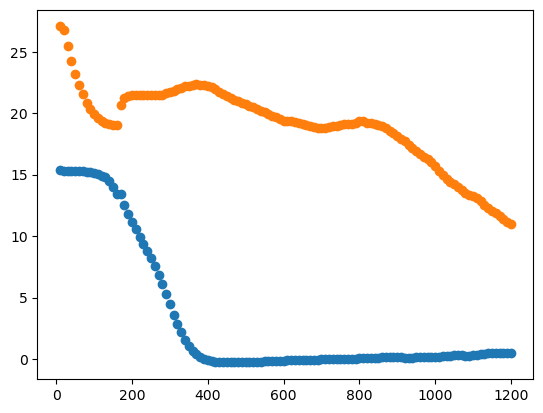

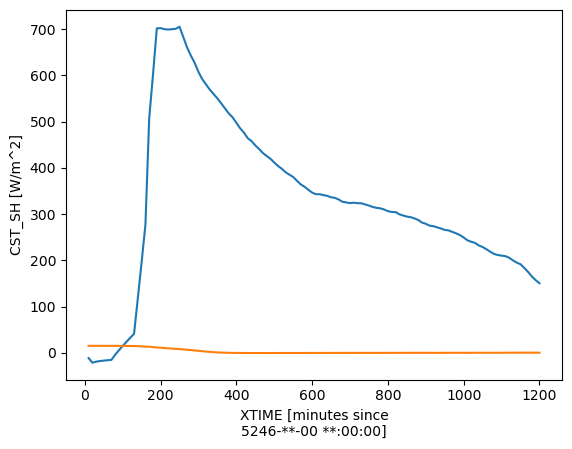

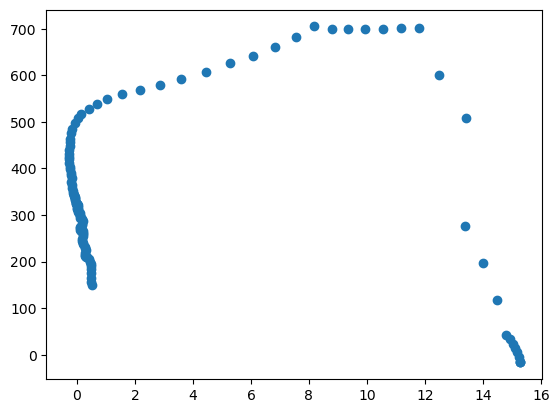

In [6]:

WSPDS = []
for i in range(0,121):
    wspd = np.sqrt(ds.CSP_U[i,5]**2 + ds.CSP_V[i,5]**2)
    WSPDS.append(wspd)
    
plt.scatter(ds.XTIME.values[1:], M[1:])
plt.scatter(ds.XTIME.values[1:], WSPDS[1:])
plt.show()
ds.CST_SH[1:].plot(x='XTIME')
plt.plot(ds.XTIME.values[1:],M[1:])
plt.show()

plt.scatter(M[5:], ds.CST_SH.values[5:])
plt.show()

In [7]:
# flux profiles


